
📈 Sorted WR Predictions (2021 Prospects):
 player_id                name   CUPPS  Predicted FPPG  Actual FPPG  Residual
     14444      Travis Etienne 74.0104       17.621136        12.50 -5.121136
     14566        Najee Harris 67.0120       12.443029        13.68  1.236971
     14962    Javonte Williams 70.5412       10.983263        10.92 -0.063263
     14877       Chuba Hubbard 51.7851        7.420604        10.33  2.909396
     15045      Kenny Gainwell 41.7417        7.168808         5.65 -1.518808
     14150      Michael Carter 45.8433        6.786646         9.59  2.803354
     14105         Trey Sermon 51.4761        6.699933         2.31 -4.389933
     15786 Rhamondre Stevenson 36.5153        5.023942        12.17  7.146058
     13418         Chris Evans 35.5405        5.009713         2.31 -2.699713
     13434           Jake Funk 31.0924        5.009683         0.05 -4.959683
     14430        Gerrid Doaks 28.8155        5.009677         6.65  1.640323
     14268     Elijah

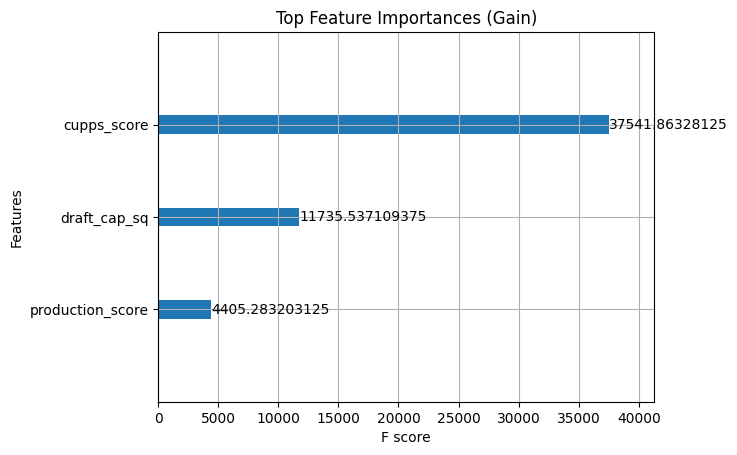

In [38]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))

import pandas as pd
import numpy as np
import decimal
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from util.db_util import DatabaseUtility
import matplotlib.pyplot as plt

# Read .bashrc and update os.environ
bashrc_path = os.path.expanduser("~/.bashrc")
if os.path.exists(bashrc_path):
    with open(bashrc_path, "r") as f:
        for line in f:
            if line.startswith("export "):
                key_value = line.replace("export ", "").strip().split("=", 1)
                if len(key_value) == 2:
                    key, value = key_value
                    os.environ[key] = value.strip().strip("'").strip('"')

# Initialize database connection
db_util = DatabaseUtility()

# Fetch training data
test_year = 2021
db_util.cursor.execute(f"""
    SELECT player_id, name, draft_cap, cupps_score, production_score, size_score, avg_fppg_nfl 
    FROM rb_model_data
    WHERE draft_year NOT IN ({test_year}, 2025)
""")
rows = db_util.cursor.fetchall()
columns = [desc[0] for desc in db_util.cursor.description]
df_train = pd.DataFrame(rows, columns=columns)

# Fetch test data (test year WR prospects)
db_util.cursor.execute(f"""
    SELECT player_id, name, draft_cap, cupps_score, production_score, size_score, avg_fppg_nfl 
    FROM rb_model_data
    WHERE draft_year = {test_year};
""")

rows_2025 = db_util.cursor.fetchall()
df_test = pd.DataFrame(rows_2025, columns=columns)
db_util.conn.close()

# Store identifiers for later merging
df_test_identifiers = df_test[["player_id", "name"]].copy()

# Convert numeric columns to float, including any decimal.Decimal values
for df in [df_train, df_test]:
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, (int, float, np.number, decimal.Decimal))).any():
            df[col] = df[col].astype(float)

df_train_numeric_cols = df_train.select_dtypes(include=[np.number]).columns
df_test_numeric_cols = df_test.select_dtypes(include=[np.number]).columns
df_train[df_train_numeric_cols] = df_train[df_train_numeric_cols].fillna(df_train[df_train_numeric_cols].mean())
df_test[df_test_numeric_cols] = df_test[df_test_numeric_cols].fillna(df_test[df_test_numeric_cols].mean())

# Define input/output
y_train = df_train["avg_fppg_nfl"]
y_test_actual = df_test["avg_fppg_nfl"]

X_train = df_train.copy()
X_test = df_test.copy()

#Add a nonlinear version of draft capital
X_train["draft_cap_sq"] = 1 / (X_train["draft_cap"].fillna(300) + 1)
X_test["draft_cap_sq"] = 1 / (X_test["draft_cap"].fillna(300) + 1)

#Exponentially weight samples with higher CUPPS scores
sample_weights = np.exp(X_train["cupps_score"] / 10)
#Only include three features in the model training to avoid noise
final_features = ["cupps_score", "production_score", "draft_cap_sq"]
#Monotone constraints allows us to tell our model that we believe these three features should generally be positively correlated with the prediction values
monotone_constraints = "(1,1,1)"

xgb_simple = xgb.XGBRegressor(
    max_depth=6, n_estimators=300, learning_rate=0.1,
    subsample=0.9, colsample_bytree=0.7,
    objective="reg:squarederror",
    monotone_constraints = monotone_constraints,    
    random_state=42
)

#Remove the features we don't want to feed the model, only feed it our final features
X_train = X_train[final_features]
X_test = X_test[final_features]
xgb_simple.fit(X_train, y_train, sample_weight=sample_weights)

#Predict on test set
y_pred = xgb_simple.predict(X_test)

#This function allows us to exponentially boost the FPPG predictions of elite prospects
#Max boost = 5 extra FPPG
#Center = 80 - the CUPPS score at which the boost hits 50%
#CUPPS 80: boost ≈ 2.5 FPPG
#CUPPS <80: less than 2.5
#CUPPS >80: more than 2.5, approaching 5 as it nears 95+
def stretch_elite_predictions(preds, cupps):
    max_boost = 3
    steepness = 0.25
    center = 80
    boost = max_boost / (1 + np.exp(-steepness * (cupps - center)))
    return preds + boost

y_pred = stretch_elite_predictions(y_pred, X_test["cupps_score"])

# Create residuals DataFrame
df_results = pd.DataFrame({
    "Actual FPPG": y_test_actual.values,
    "Predicted FPPG": y_pred,
    "Residual (Actual - Predicted)": y_test_actual.values - y_pred
})

# Merge predictions, actuals, and residuals
df_predictions = df_test_identifiers.copy()
df_predictions["CUPPS"] = X_test["cupps_score"]
df_predictions["Predicted FPPG"] = y_pred
df_predictions["Actual FPPG"] = y_test_actual.values
df_predictions["Residual"] = df_predictions["Actual FPPG"] - df_predictions["Predicted FPPG"]

# Sort by predicted FPPG
df_predictions = df_predictions.sort_values(by="Predicted FPPG", ascending=False).reset_index(drop=True)

# Display
print(f"\n📈 Sorted WR Predictions ({test_year} Prospects):")
print(df_predictions.to_string(index=False))

xgb.plot_importance(xgb_simple, importance_type='gain', max_num_features=10)
plt.title("Top Feature Importances (Gain)")
plt.show()
